# A Tensor-Based Algorithm for High-Order Graph Matching

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sns.set()
%matplotlib inline

In [2]:
from typing import Tuple

import numpy as np


def generate_points(N: int) -> np.ndarray:
    """It randomly generates N points in [-1, 1] x [-1, 1]"""
    return 2*(np.random.random((N, 2)) - 0.5)


def transform_points(
        points: np.ndarray, theta: float = 0, scale: float = 1, sigma: float =1e-5
) -> np.ndarray:
    """
    Given a set of points np.ndarray of shape (N,2).
    This function adds some gaussian noise with a variance of sigma, apply a rotation of theta (in radians)
    and a scaling of a factor scale.
    """
    N = points.shape[0]
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]] )
    noise = np.random.normal(loc=0, scale=sigma, size = (N,2))
    return np.dot(points, rotation_matrix.T)*scale + noise


def generate_dataset(
        N: int, theta: float, scale: float, sigma: float
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given an integer N, it generates N points in [-1, 1] x [-1, 1] and applies a rotation,
    a scaling and add some noise.
    Finally it returns N generated points and their transformation.
    :param N: Number of points in the dataset
    :param theta: Angle for the rotation (in radians)
    :param scale: Scaling factor
    :param sigma: Noise variance
    :return:
    """
    data1 = generate_points(N)
    data2 = transform_points(data1, theta, scale, sigma)
    return data1, data2


Text(0.5, 1.0, 'Example of dataset generated for N =25, sigma=0.01, theta=pi/10, scale=2.0')

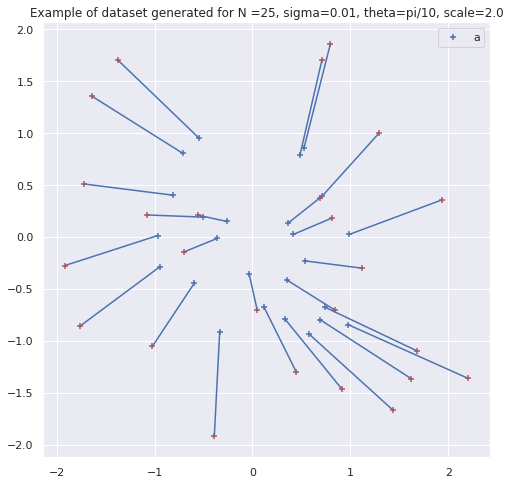

In [3]:
sigma = 1e-2
scaling_factor = 2.0
theta =np.pi/20
N1 = 25
N2 = 25
points1 = generate_points(N1)
points2 = transform_points(points1, theta, scaling_factor, sigma)

fig = plt.figure(figsize=(8,8))
plt.scatter(points1[:,0], points1[:,1], marker='+', color='b')
plt.legend(['a'])
plt.scatter(points2[:,0], points2[:, 1], marker='+', color='r')
for (x1,y1), (x2,y2) in zip(points1, points2):
    plt.plot([x1,x2], [y1, y2], color='b')
plt.title(f'Example of dataset generated for N ={N1}, sigma={sigma}, theta=pi/10, scale={scaling_factor}')


# Blue markers are original points, red markers points transformed and there are lines between points and their transformations

In [4]:
t = 20 # Number of triangles selected per points in the first dataset
nNN=300 # Number of triangles 

###### Extract triangles for the first dataset

In [5]:
from typing import Tuple

import numpy as np


def pick_triangles(points: np.ndarray, t: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given a numpy ndarray of points of shape (N,2) this function extracts t triangles from that
    containing the frist points, t triangles containing the second one and so forth so on.
    :param points: numpy ndarray of points (N,2)
    :param t: number of triangles to extract by point
    :return: numpy ndarray of shape (N,t,3,2)
    -> first dimension == points
    -> second dimension == triangles for one  point
    --> thirs dimension == points of the triangles
    --> 4th dimension == coordinates of the point
    and a  numpy ndarray of shape (N,t,3,2) containing the indexes of the selected triangles of
    shape (N,t,3) --> third dimension is the indexes of the triangle
    """
    selected_triangles_index = []
    N1 = points.shape[0]
    for i in range(N1):
        indexes = np.array(
            [np.random.choice(np.arange(1, N1), size=2, replace=False) for _ in range(t)])
        indexes = (indexes + i) % N1
        indexes = np.concatenate([i * np.ones((t, 1), dtype='int'), indexes], axis=1)
        selected_triangles_index.append(indexes)
    selected_triangles_index = np.vstack(selected_triangles_index)
    
    selected_triangles = points[selected_triangles_index].reshape((-1, t, 3, 2))
    selected_triangles_index = selected_triangles_index.reshape((-1, t, 3))
    return selected_triangles, selected_triangles_index


In [6]:
triangles1, triangles1_indexes = pick_triangles(points1, t)

In [7]:
triangles1.shape

(25, 20, 3, 2)

In [8]:
def extract_all_triangles(points: np.ndarray) -> np.ndarray:
    """
    Given a numpy array of points returns all the triangles that can be built with those points
    :param points: numpy array of points (shape = (N,2))
    :return: numpy array of triangles of shape (N, N, N, 3, 2)
    """
    N = points.shape[0]
    all_indexes = np.array([(i, j, k) for i in range(N) for j in range(N) for k in range(N)])
    return points[all_indexes].reshape((N, N, N, 3, 2))

In [12]:
triangles2 = extract_all_triangles(points2) 

###### Compute features

In [10]:
def compute_features(triangles):
    # input shape (-1, 3, 2)
    vect = np.concatenate([
        triangles[:, 1] - triangles[:, 0],
        triangles[:, 2] - triangles[:, 1],
        triangles[:, 0] - triangles[:, 2]
    ], axis=1).reshape((-1,3,2))
    norm = np.linalg.norm(vect, axis=2).reshape((-1,3,1))
    normalized_vect = vect/(norm + 1e-12)
    return np.concatenate([
        np.linalg.det(normalized_vect[:,[0,2],:]).reshape((-1,1)),
        np.linalg.det(normalized_vect[:,[1,0],:]).reshape((-1,1)),
        np.linalg.det(normalized_vect[:,[2,1],:]).reshape((-1,1)),
    ], axis=1)

In [13]:
features1 = compute_features(triangles1.reshape((-1,3,2)))

features2 = compute_features(triangles2.reshape((-1,3,2))).reshape((N2,N2,N2,3))

for i in range(N2):
    for j in range(N2):
        for k in range(N2):
            if i == j or j == k or i == k:
                features2[i, j, k] = -10

###### Find nearest neighbors


In [14]:
def get_closest_features(
        features1: np.ndarray, features2: np.ndarray, n: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given two set of features, for each feature in features1 it retrieves the n nearest features in
    features2.
    :param features1: numpy ndarray of features
    :param features2: numpy ndarray of features
    :param n: number of nearest features to extract
    :return: A tuple of numpy array of size (N1,n) which represents the distance between features
    of features1 and the n nearest in features2 and a numpy array of the indexes of the nearest
    features in features2.
    """
    tree = scipy.spatial.KDTree(features2.reshape((-1, 3)))
    nearest_distances, nearest_neighbors = tree.query(features1.reshape((-1, 3)), n)
    return nearest_distances, nearest_neighbors

In [48]:
nearest_distances, nearest_neighbors = get_closest_features(features1, features2, nNN)

In [49]:
nearest_neighbors_indexes = np.concatenate([
    (nearest_neighbors.reshape((-1,1)) // (N2**2) % N2) ,
    (nearest_neighbors.reshape((-1,1)) // N2)%N2,
    nearest_neighbors.reshape((-1,1)) %  N2] ,axis = 1).reshape((-1,t,nNN,3))

In [50]:
nearest_neighbors = nearest_neighbors.reshape((-1, t, nNN))

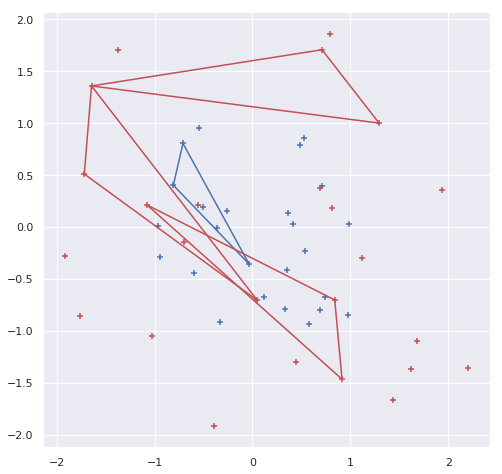

In [51]:
fig = plt.figure(figsize=(8,8))
plt.scatter(points1[:,0], points1[:,1], marker='+')
plt.scatter(points2[:,0], points2[:, 1], marker='+', color='r')
i1 = 2
t1 = 5
for triangle in [triangles1[i1][t1]]:
    for i in range(len(triangle)):
        plt.plot([triangle[i][0], triangle[(i+1)%3][0]],
                 [triangle[i][1], triangle[(i+1)%3][1]], color='b')
nearest_triangles = triangles2.reshape((-1,6))[nearest_neighbors[i1][t1]].reshape((-1,3,2))
for triangle in nearest_triangles[:3]:
    for i in range(len(triangle)):
        plt.plot([triangle[i][0], triangle[(i+1)%3][0]],
                 [triangle[i][1], triangle[(i+1)%3][1]], color='r')


# Compute potential

In [52]:
potentials = np.exp(-(nearest_distances / np.mean(nearest_distances) ))

In [53]:
potentials = potentials.reshape((N1,t,nNN))

# Power iteration

In [57]:
def power_iteration(
        triangles1_indexes: np.ndarray, nearest_neighbors_indexes: np.ndarray,
        potentials: np.ndarray,  N1:int, N2:int, eps = 1e-5
) -> np.ndarray:
    maxiter = 100
    Vn_1 = np.ones((N1, N2))
    for epoch in range(maxiter):
        print(f'Epoch {epoch+1}')
        Vn = np.ones((N1, N2))
        for i1 in range(N1):
            for t1, (_, j1, k1) in enumerate(triangles1_indexes[i1]):
                for t2, (i2, j2, k2) in enumerate(nearest_neighbors_indexes[i1][t1]):
                    Vn[i1, i2] += potentials[i1, t1, t2] * Vn_1[j1, j2] * Vn_1[k1, k2]
                    Vn[j1, j2] += potentials[i1, t1, t2] * Vn_1[i1, i2] * Vn_1[k1, k2]
                    Vn[k1, k2] += potentials[i1, t1, t2] * Vn_1[j1, j2] * Vn_1[i1, i2]
        Vn = Vn / np.linalg.norm(Vn)
        print(f'||Vn - Vn_1|| = {np.linalg.norm(Vn - Vn_1)}')
        if np.linalg.norm(Vn - Vn_1) < eps:
            break
        Vn_1 = Vn
    print(f'Stop after {epoch} iterations')
    mapping = np.argmax(Vn, axis=1)
    return mapping

In [58]:
mapping = power_iteration(triangles1_indexes, nearest_neighbors_indexes, potentials, N1, N2)

Epoch 1
||Vn - Vn_1|| = 24.016524559530648
Epoch 2
||Vn - Vn_1|| = 0.11570206287225676
Epoch 3
||Vn - Vn_1|| = 0.011193850849393701
Epoch 4
||Vn - Vn_1|| = 0.002336917723891137
Epoch 5
||Vn - Vn_1|| = 0.0006456083957817274
Epoch 6
||Vn - Vn_1|| = 0.0001913511974651947
Epoch 7
||Vn - Vn_1|| = 5.7682419493102914e-05
Epoch 8
||Vn - Vn_1|| = 1.746328619760823e-05
Epoch 9
||Vn - Vn_1|| = 5.2931292035638024e-06
Stop after 8 iterations


In [59]:
print(f'Good match : {np.argwhere(mapping == np.arange(0, N1)).shape[0]}/{N1}')

Good match : 25/25


In [60]:
def plot_solution(points1, points2, mapping):
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points1[:,0], points1[:,1], marker='+')
    plt.scatter(points2[mapping][:,0], points2[mapping][:, 1], marker='+', color='r')
    for (x1,y1), (x2,y2) in zip(points1, points2[mapping]):
        plt.plot([x1,x2], [y1, y2], color='b')
    for (x1,y1), (x2,y2) in zip(points1, points2):
        plt.plot([x1,x2], [y1, y2], color='r')



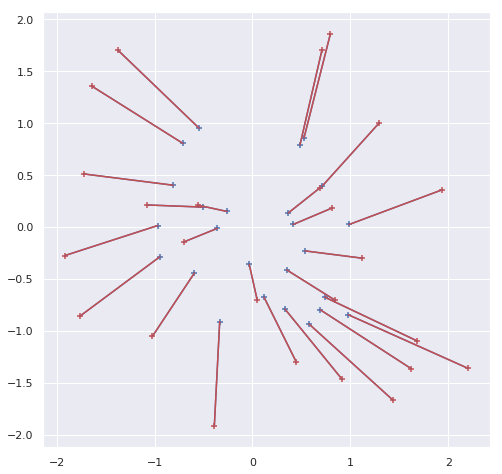

In [40]:
plot_solution(points1, points2, mapping)